In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import time

print("--- Running Setup: Imports and Path ---")
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path")

--- Running Setup: Imports and Path ---
Added '/Users/dingding/Desktop/大学博士阶段科研资料/课程资料/25spring/Topological and Geometric Data Reduction and Visualization/Project' to sys.path


In [2]:
# Cell 2: Data Loading, Reshaping, and Ground Truth Definition
print("--- Loading Data ---")
try:
    from src.io_utils import load_face_data
    print("Successfully imported load_face_data")
except ImportError as e:
    print(f"Failed to import load_face_data: {e}")
    load_face_data = None

face_data = None
if load_face_data:
    face_data = load_face_data(data_dir='../data', file_name='face.mat')
    if face_data is not None and face_data.ndim == 3 and face_data.shape[0] == 33:
         print(f"Data loaded successfully! Shape: {face_data.shape}")
    else:
         print(f"Data loaded, but shape is not the expected 3D shape.")
         face_data = None
else:
    print("Cannot proceed without load_face_data function.")

print("\n--- Reshaping Data ---")
flattened_face_data = None
if face_data is not None:
    n_samples = face_data.shape[0]
    n_features = face_data.shape[1] * face_data.shape[2]
    flattened_face_data = face_data.reshape((n_samples, n_features))
    print(f"Data reshaped successfully to: {flattened_face_data.shape}")
if flattened_face_data is None:
     print("Error: Flattened data is not available.")

print("\n--- Defining Ground Truth ---")
ground_truth_order_indices = None
# Final agreed-upon order (0-based indices)
final_order = np.array([
    9, 20, 22, 14, 10, 4, 7, 0, 32, 13, 19, 12, 1, 30, 26, 11, 8, 5,
    2, 29, 15, 16, 25, 21, 31, 17, 23, 6, 24, 27, 28, 3, 18
])
if len(final_order) == 33 and len(np.unique(final_order)) == 33:
    ground_truth_order_indices = final_order
    print("Ground Truth order defined.")
else:
    print("Error in final_order definition. Please check the array.")

print("\n--- Data Prep Complete ---")

--- Loading Data ---
Successfully imported load_face_data
Keys in face.mat: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'id'])
Data loaded successfully! Shape: (33, 92, 112)

--- Reshaping Data ---
Data reshaped successfully to: (33, 10304)

--- Defining Ground Truth ---
Ground Truth order defined.

--- Data Prep Complete ---


In [3]:
# Cell 3: Run All Embeddings (PCA, MDS, Isomap, LLE, LTSA, MLLE, HLLE, Spectral, t-SNE)
print("--- Running Embeddings ---")
embeddings_dict = {} # Store all results here

if flattened_face_data is not None:
    start_time_all = time.time()
    # Import all embedding functions
    try:
        from src.embedding import run_pca, run_mds, run_isomap, run_lle, run_tsne, run_spectral
        print("Successfully imported embedding functions.")
    except ImportError as e:
        print(f"Failed to import from src.embedding: {e}")
        # Set functions to None if import fails
        run_pca, run_mds, run_isomap, run_lle, run_tsne, run_spectral = (None,) * 6

    # --- Parameters ---
    n_components = 2
    n_neighbors_default = 5
    n_neighbors_hlle = 10 # Use k=10 for HLLE
    perplexity_tsne = 10
    random_state = 42

    # --- Run Methods ---
    # PCA
    if run_pca:
        print("-" * 10, "Running PCA", "-" * 10)
        embeddings_dict['PCA'], _ = run_pca(flattened_face_data, n_components=n_components)
    # MDS
    if run_mds:
        print("-" * 10, "Running MDS", "-" * 10)
        embeddings_dict['MDS'], _ = run_mds(flattened_face_data, n_components=n_components, random_state=random_state)
    # Isomap
    if run_isomap:
        print("-" * 10, "Running Isomap", "-" * 10)
        embeddings_dict['Isomap'], _ = run_isomap(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_default)
    # LLE variants
    if run_lle:
        print("-" * 10, "Running LLE", "-" * 10)
        embeddings_dict['LLE'], _ = run_lle(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_default, method='standard', random_state=random_state)
        print("-" * 10, "Running LTSA", "-" * 10)
        embeddings_dict['LTSA'], _ = run_lle(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_default, method='ltsa', random_state=random_state)
        print("-" * 10, "Running MLLE", "-" * 10)
        embeddings_dict['MLLE'], _ = run_lle(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_default, method='modified', random_state=random_state)
        print("-" * 10, f"Running HLLE (k={n_neighbors_hlle})", "-" * 10)
        try:
            embeddings_dict['HLLE'], _ = run_lle(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_hlle, method='hessian', random_state=random_state)
        except Exception as e:
            print(f"HLLE failed with k={n_neighbors_hlle}: {e}. Setting result to None.")
            embeddings_dict['HLLE'] = None
    # Spectral Embedding
    if run_spectral:
        print("-" * 10, "Running Spectral Embedding", "-" * 10)
        embeddings_dict['Spectral'], _ = run_spectral(flattened_face_data, n_components=n_components, n_neighbors=n_neighbors_default, random_state=random_state)
    # t-SNE
    if run_tsne:
        print("-" * 10, "Running t-SNE", "-" * 10)
        embeddings_dict['t-SNE'], _ = run_tsne(flattened_face_data, n_components=n_components, perplexity=perplexity_tsne, random_state=random_state)

    end_time_all = time.time()
    print(f"\n--- All Embeddings computed in {end_time_all - start_time_all:.2f} seconds ---")

    print("\nEmbedding Shapes:")
    for name, emb in embeddings_dict.items():
        if emb is not None: print(f" {name}: {emb.shape}")
        else: print(f" {name}: Failed or not run.")
else:
    print("Cannot run embeddings: flattened_face_data is not available.")

--- Running Embeddings ---
Install it via: pip install scikit-learn-extra
Successfully imported embedding functions.
---------- Running PCA ----------
Running PCA with n_components=2...
PCA completed.
---------- Running MDS ----------
Running MDS with n_components=2...


/opt/anaconda3/envs/tgdr39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 152 with stress 195547039.71726066
breaking at iteration 234 with stress 194136196.054825
breaking at iteration 149 with stress 186688840.16468853
breaking at iteration 115 with stress 194855075.18209332
MDS completed.
---------- Running Isomap ----------
Running Isomap with n_components=2, n_neighbors=5...
Isomap completed.
---------- Running LLE ----------
Running LLE (method='standard') with n_components=2, n_neighbors=5...
LLE (method='standard') completed.
---------- Running LTSA ----------
Running LLE (method='ltsa') with n_components=2, n_neighbors=5...
LLE (method='ltsa') completed.
---------- Running MLLE ----------
Running LLE (method='modified') with n_components=2, n_neighbors=5...
LLE (method='modified') completed.
---------- Running HLLE (k=10) ----------
Running LLE (method='hessian') with n_components=2, n_neighbors=10...
LLE (method='hessian') completed.
---------- Running Spectral Embedding ----------
Running Spectral Embedding with n_components=

In [4]:
# Cell 4: Calculate and Display All Evaluation Metrics
print("\n--- Calculating Metrics ---")
metrics_df = None # Initialize
# Import metric function (ensure src/metrics.py has the updated compute_all_metrics)
try:
    from src.metrics import compute_all_metrics
    print("Successfully imported compute_all_metrics from src.metrics")
except ImportError as e:
    print(f"Failed to import from src.metrics: {e}")
    compute_all_metrics = None

# Check if required data exists
if flattened_face_data is None:
    print("Error: flattened_face_data is not defined.")
elif ground_truth_order_indices is None:
    print("Error: ground_truth_order_indices is not defined.")
elif not embeddings_dict:
    print("Error: embeddings_dict is empty or not defined.")
elif compute_all_metrics is None:
     print("Error: compute_all_metrics function not available.")
else:
    # Filter out None values from embeddings before calculating metrics
    valid_embeddings_final = {name: emb for name, emb in embeddings_dict.items() if emb is not None}

    if not valid_embeddings_final:
         print("Error: No valid embeddings found to compute metrics.")
    else:
        # Compute metrics
        metrics_k = 5 # k for Trustworthiness/Continuity
        metrics_df = compute_all_metrics(flattened_face_data,
                                         valid_embeddings_final,
                                         ground_truth_order_indices,
                                         n_neighbors=metrics_k)

        # Display results
        print(f"\n--- Evaluation Metrics (k={metrics_k} for T&C) ---")
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(metrics_df)


--- Calculating Metrics ---
Successfully imported compute_all_metrics from src.metrics
Note: TAE for MDS was calculated using reversed order (min(366, 350)).
Note: TAE for LLE was calculated using reversed order (min(544, 14)).
Note: TAE for LTSA was calculated using reversed order (min(544, 36)).
Note: TAE for MLLE was calculated using reversed order (min(544, 22)).
Note: TAE for HLLE was calculated using reversed order (min(544, 16)).
Note: TAE for Spectral was calculated using reversed order (min(544, 14)).

--- Evaluation Metrics (k=5 for T&C) ---
     Method  TAE (min)  Trustworthiness  Continuity
2    Isomap          6           0.9818      0.9898
3       LLE         14           0.9624      0.9728
7  Spectral         14           0.9554      0.9644
6      HLLE         16           0.9539      0.9396
5      MLLE         22           0.9840      0.9850
0       PCA         30           0.9782      0.9908
4      LTSA         36           0.9549      0.9452
8     t-SNE        262   


--- Visualizing Embeddings (Scatter) ---


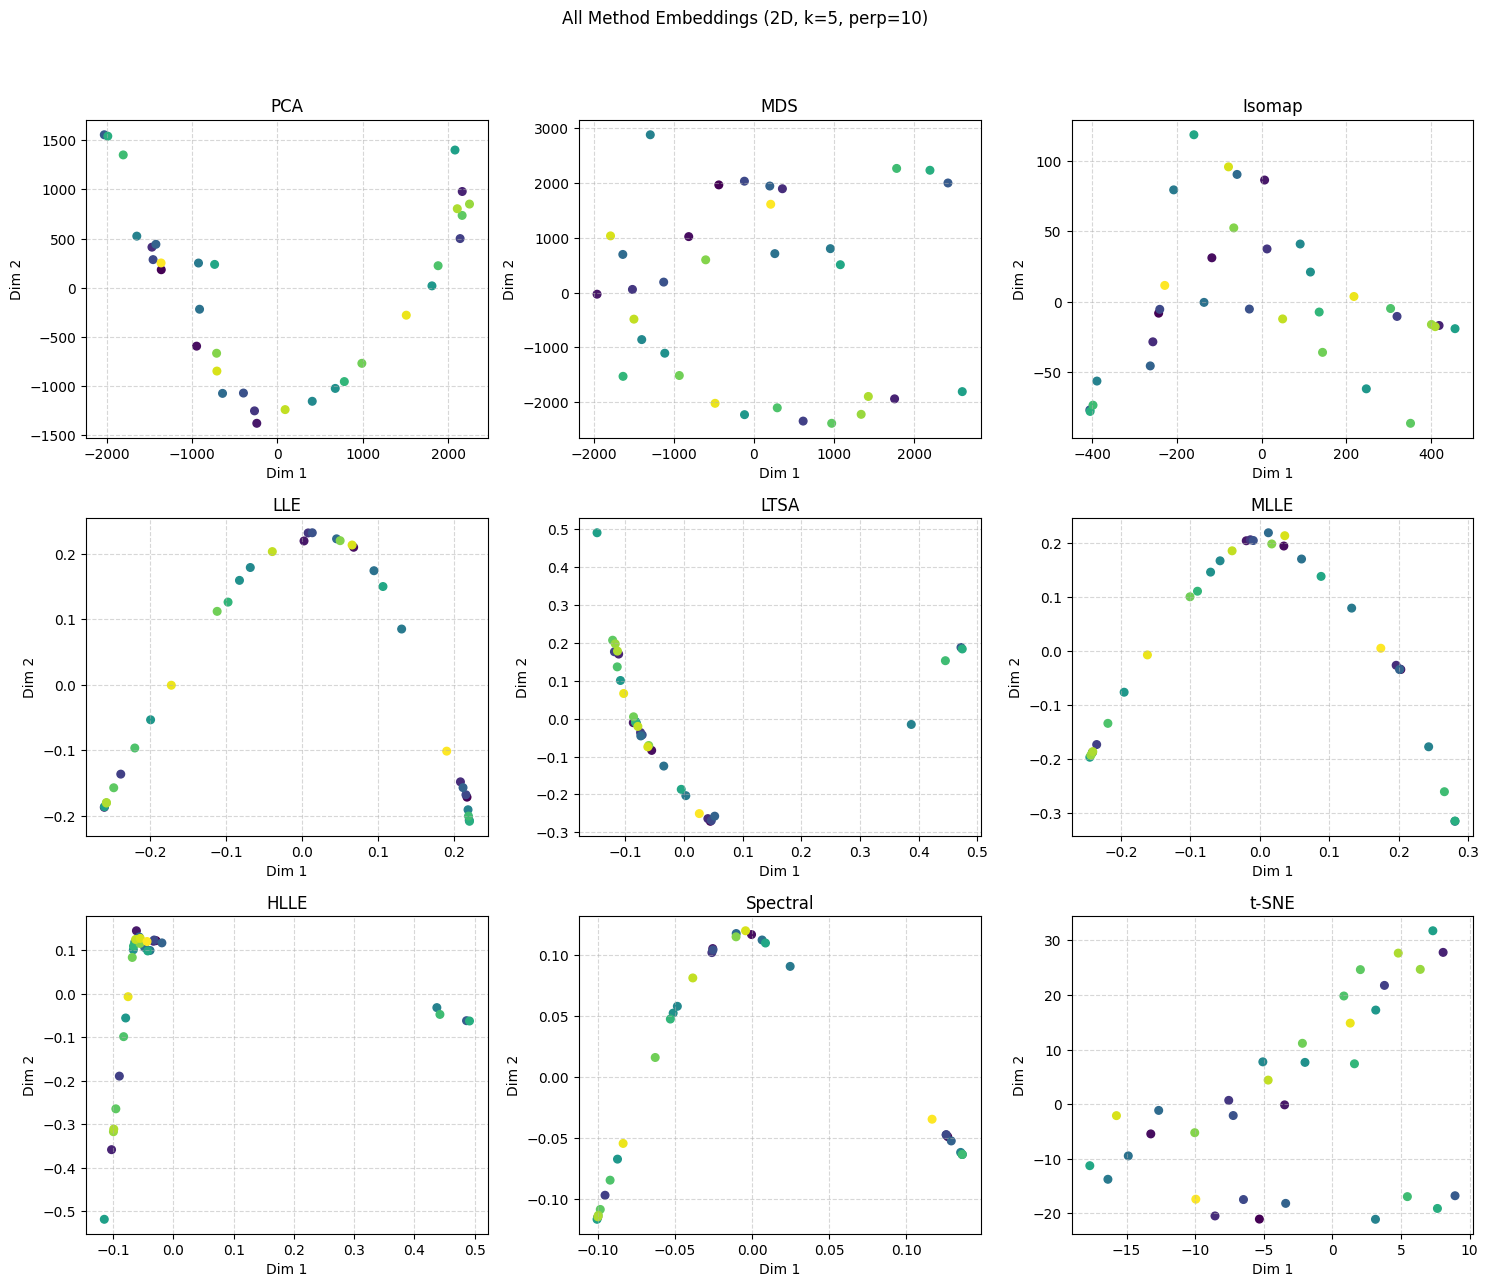

In [5]:
# Cell 5: Visualize All Embeddings (Scatter Plots)
print("\n--- Visualizing Embeddings (Scatter) ---")
if not embeddings_dict:
     print("Error: embeddings_dict not defined or empty.")
else:
    available_embeddings_viz = {name: emb for name, emb in embeddings_dict.items() if emb is not None}

    if not available_embeddings_viz:
        print("No valid embeddings available for plotting.")
    else:
        n_methods_viz = len(available_embeddings_viz)
        n_cols_viz = 3 # Arrange in 3 columns
        n_rows_viz = (n_methods_viz + n_cols_viz - 1) // n_cols_viz
        fig, axes = plt.subplots(n_rows_viz, n_cols_viz, figsize=(n_cols_viz * 5, n_rows_viz * 4.5), squeeze=False)

        k_n = n_neighbors_default if 'n_neighbors_default' in locals() else 'N/A'
        p_tsne = perplexity_tsne if 'perplexity_tsne' in locals() else 'N/A'
        fig.suptitle(f'All Method Embeddings (2D, k={k_n}, perp={p_tsne})')

        axes_flat_viz = axes.flatten()
        plot_idx_viz = 0
        for name, emb in available_embeddings_viz.items():
            if plot_idx_viz < len(axes_flat_viz):
                 ax = axes_flat_viz[plot_idx_viz]
                 scatter = ax.scatter(emb[:, 0], emb[:, 1], c=np.arange(emb.shape[0]), cmap='viridis', s=30)
                 ax.set_title(name)
                 ax.set_xlabel('Dim 1')
                 ax.set_ylabel('Dim 2')
                 ax.grid(True, linestyle='--', alpha=0.5)
                 plot_idx_viz += 1
            else: break

        for j in range(plot_idx_viz, len(axes_flat_viz)): axes_flat_viz[j].axis('off')
        if plot_idx_viz > 0: plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


--- Plotting All Embeddings with Images ---
Found 9 valid embeddings to plot.


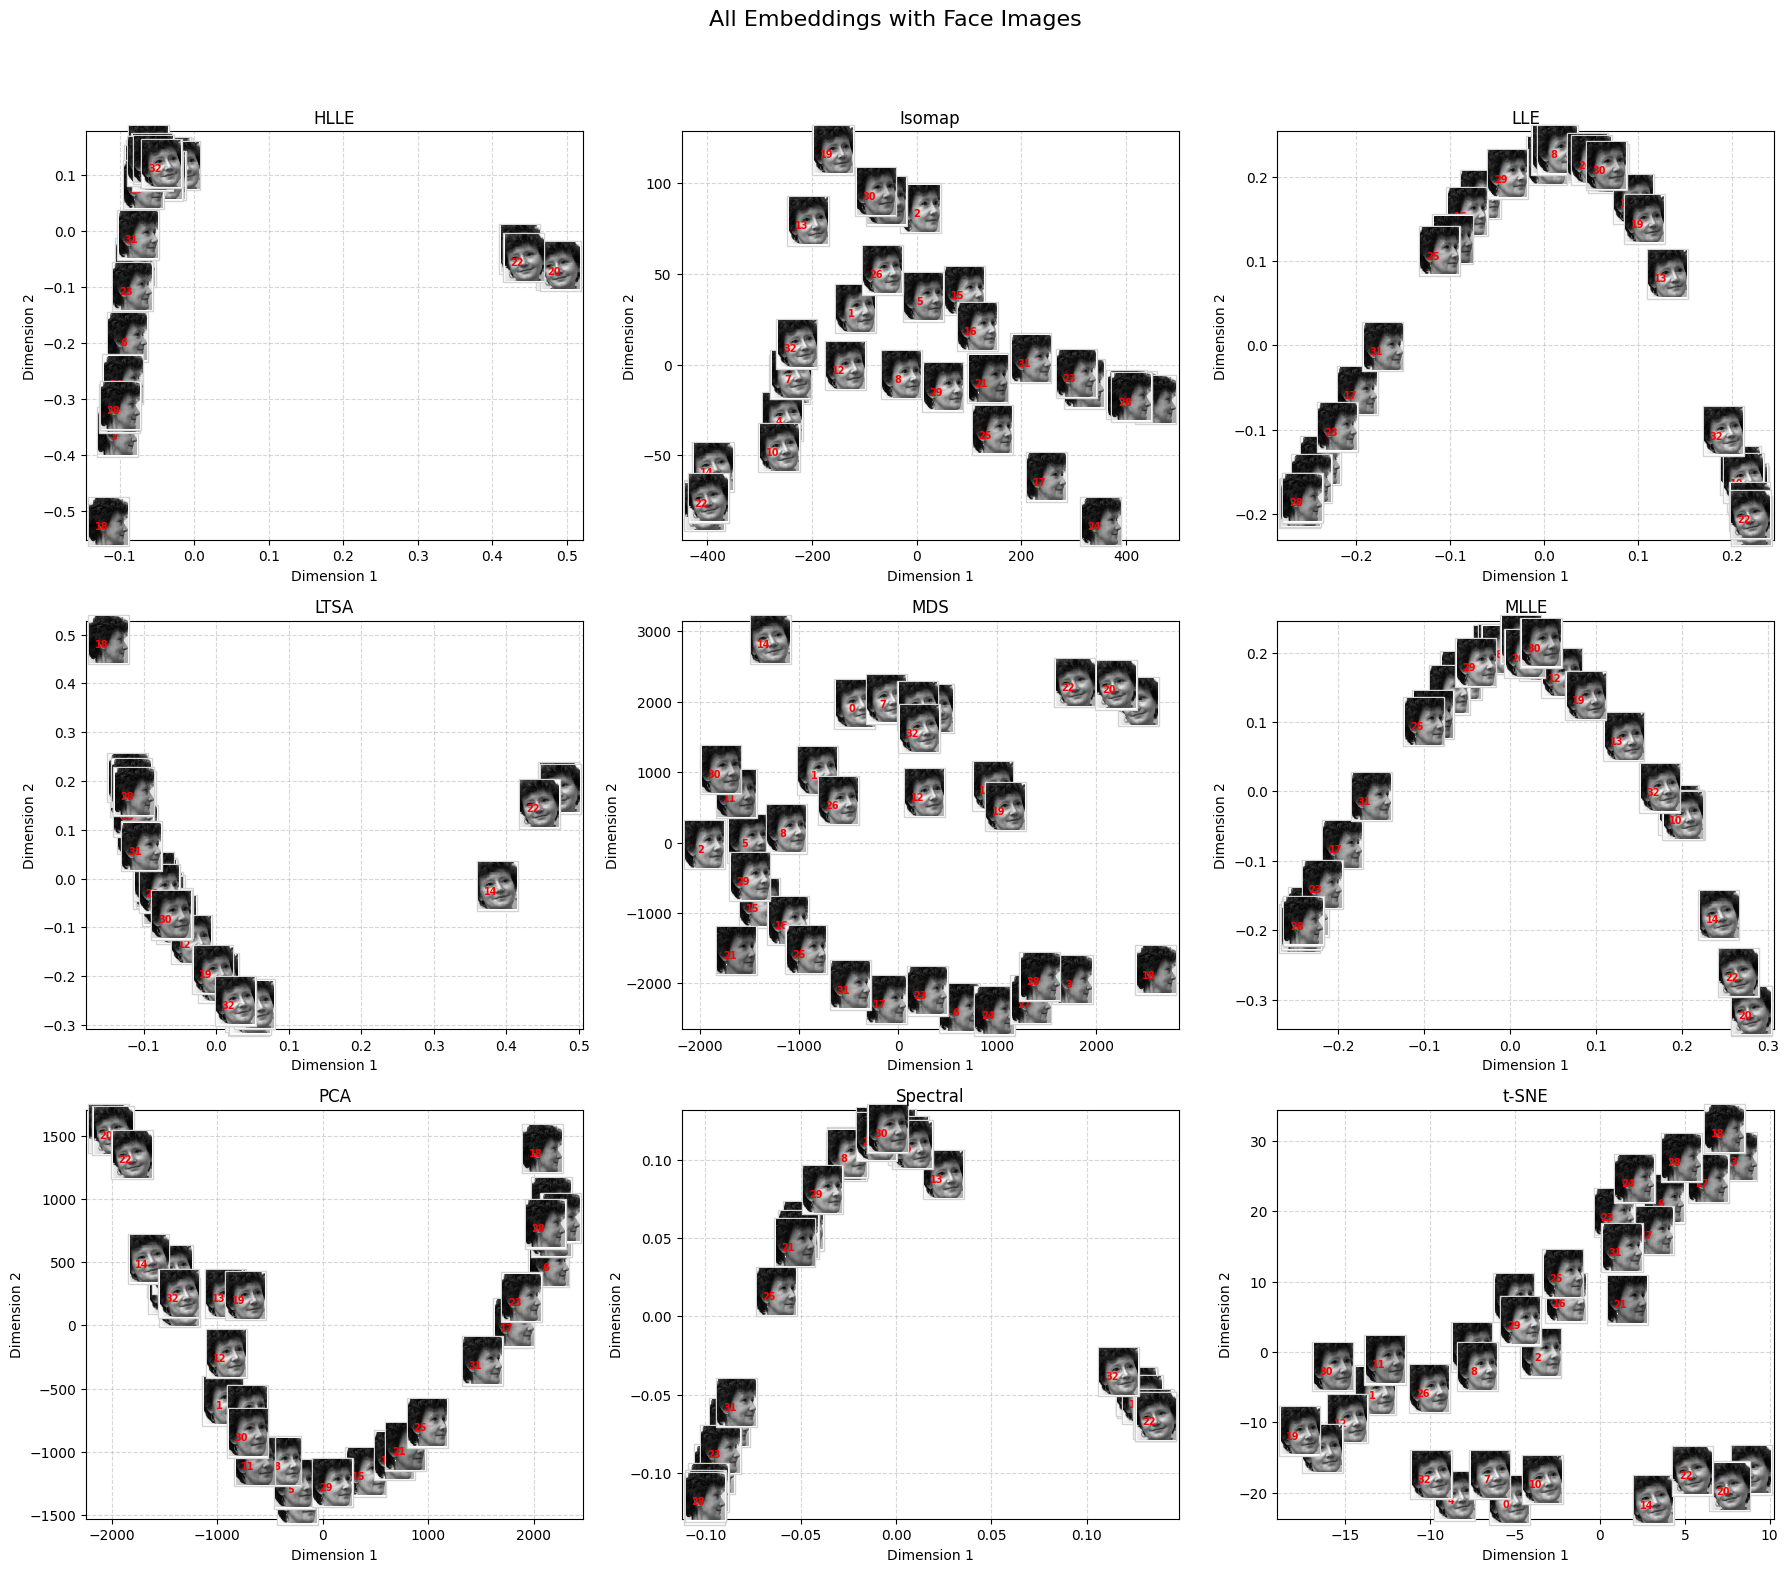


--- Image Plotting Complete ---


In [6]:
# Cell 6: Visualize ALL Embeddings with Images (3x3 Grid)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

print("\n--- Plotting All Embeddings with Images ---")

# Check if necessary data exists
if ('face_data' not in locals() or face_data is None or face_data.ndim != 3 or face_data.shape[0] != 33):
    print("Error: face_data not available or has incorrect shape.")
elif ('valid_embeddings_final' not in locals() or not valid_embeddings_final):
    print("Error: No valid embeddings found in 'valid_embeddings_final'. Please run Cell 4 first.")
else:
    n_methods_all = len(valid_embeddings_final)
    print(f"Found {n_methods_all} valid embeddings to plot.")

    # Determine grid size (aim for 3x3 if 9 methods)
    n_cols = 3
    n_rows = (n_methods_all + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5.5), squeeze=False) # Adjust size
    fig.suptitle("All Embeddings with Face Images", fontsize=16)
    axes_flat = axes.flatten()
    plot_idx = 0

    # Sort embedding names for consistent plotting order (optional)
    sorted_method_names = sorted(valid_embeddings_final.keys())

    # --- Loop through each method ---
    # for name, embedding in valid_embeddings_final.items():
    for name in sorted_method_names: # Iterate in sorted order
        embedding = valid_embeddings_final[name]
        if plot_idx >= len(axes_flat): break

        ax = axes_flat[plot_idx]
        ax.set_title(f"{name}")
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")

        x_coords = embedding[:, 0]
        y_coords = embedding[:, 1]

        # --- Loop through each data point (face) ---
        for i in range(face_data.shape[0]):
            x, y = x_coords[i], y_coords[i]
            img = face_data[i, :, :].T # Get transposed image

            # Create and add image annotation box
            try:
                 # Adjust zoom for clarity in a 3x3 grid
                 imagebox = OffsetImage(img, zoom=0.3, cmap='gray')
                 imagebox.image.axes = ax
                 # Add frame (like MDS example)
                 ab = AnnotationBbox(imagebox, (x, y),
                                     xycoords='data',
                                     frameon=True,
                                     pad=0.1,
                                     bboxprops=dict(edgecolor='lightgray'))
                 ax.add_artist(ab)

                 # Add original index number (0-based) next to the image
                 # Adjust xytext offset based on zoom/layout
                 ax.text(x, y, str(i), color='red', fontsize=7, weight='bold',
                         ha='right', va='top') # Position relative to xy

            except Exception as e:
                 print(f"Warn: Img {i} for {name}: {e}")


        # Adjust plot limits and add grid
        ax.update_datalim(np.column_stack([x_coords, y_coords]))
        ax.autoscale_view()
        ax.grid(True, linestyle='--', alpha=0.5)
        plot_idx += 1

    # Hide any unused subplots
    for j in range(plot_idx, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("\n--- Image Plotting Complete ---")